In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
from food.psql import *
from food.paths import *
from mytools.tools import *
import pandas as pd
from food.segment import *
import requests
import torch

dev
../checkpoints/SETR_Naive_ReLeM


/home/dima/FoodSeg103-Benchmark-v1/nbs/../mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [3]:
foods = pd.read_sql("""select f.*
                        from food.foods_prompted f
                        """,engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()
food_clips = series2tensor(foods['clip'])

/home/dima/mytools/mytools/tools.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [4]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [5]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [30.00, 30.0]
plt.rcParams["figure.autolayout"] = True

In [1]:
url = 'https://image.shutterstock.com/z/stock-photo-selective-focus-of-seblak-kuah-famous-street-food-originating-from-bandung-west-java-cooked-1793705947.jpg'

In [7]:
mask = save_segments(url)
total = mask.shape[0]*mask.shape[1]
clases = np.unique(mask)[1:]

In [8]:
photo_id = url.split('/')[-1]
urls = []
areas = []
classes = []
for c in clases: 
    area = mask[mask==c].shape[0]
    if area> 10*10:
        areas.append(area)
        urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_{c}.jpg')
        classes.append(c)

In [9]:
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df=clip_df.reset_index(drop=True)
clip_df['area'] = areas
clip_df['class'] = classes
clip_df = clip_df.sort_values('area',ascending = False)

/tmp/ipykernel_1038725/113361347.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_1038725/113361347.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_1038725/113361347.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_1038725/113361347.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_1038725/113361347.py:3: FutureWarning: The frame.append method is deprecated 

In [10]:
calorie_dict = clip_df.set_index('class')['energy'].to_dict()

In [11]:
from copy import copy

In [12]:
calorie_mask = np.zeros(mask.shape)

In [13]:
for c in classes: calorie_mask[mask==c]=calorie_dict[c]

In [14]:
np.unique(calorie_mask)

array([  0.,   6.,  26.,  27.,  41.,  74., 106., 152.])

In [15]:
image = get_image_from_url(url)

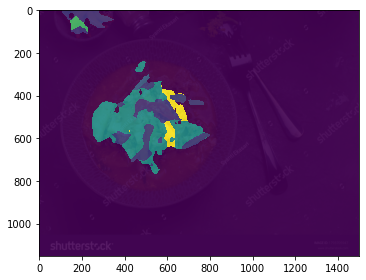

In [17]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(calorie_mask, interpolation='none', alpha=0.9)

In [113]:
clip_df

,id,description,category,energy,protein,carb,fat,text,clip,score,area,class
7,1103416,"Artichoke, frozen, cooked, fat added",Other vegetables and combinations,74.0,2.81,11.57,2.87,the food is other vegetables and combinations ...,"[0.038708072, -0.0052777464, -0.009069385, 0.0...",0.244991,81381,103
1,1103373,"Pepper, banana, raw",Other vegetables and combinations,27.0,1.66,5.35,0.45,the food is other vegetables and combinations ...,"[0.05288567, 0.0057883444, -0.026471268, -0.00...",0.246689,25006,76
6,1103372,"Pepper, sweet, red, raw",Other red and orange vegetables,26.0,0.99,6.03,0.30,the food is other red and orange vegetables . ...,"[0.037836775, -0.011300974, -0.030213699, -0.0...",0.219144,20464,94
5,1099628,"Moo Shu pork, without Chinese pancake",Stir-fry and soy-based sauce mixtures,152.0,10.43,4.04,10.61,the food is stir-fry and soy-based sauce mixtu...,"[0.046197023, 0.0019993146, -0.010043286, 0.01...",0.239528,9863,92
2,1098156,"Meat, baby food, NS as to type, NS as to strai...",Baby food: meat and dinners,106.0,12.86,1.26,5.21,the food is baby food meat and dinners . it ha...,"[0.0035682924, -0.0013088994, 0.020203583, 0.0...",0.236651,3023,84
3,1103714,"Mushroom soup, cream of, canned, reduced sodiu...",Soups,26.0,0.61,4.11,0.86,the food is soups . it has a little bit of n...,"[0.036990557, 0.020746004, 0.019117268, 0.0312...",0.212886,2028,86
4,1103452,"Green beans, canned, reduced sodium, cooked wi...",String beans,41.0,1.10,4.20,2.62,the food is string beans . it has a little bit...,"[0.047265675, 0.020352881, -0.0034479606, 0.02...",0.263416,1918,88
0,1100118,"Beef broth, less or reduced sodium, canned or ...",Soups,6.0,1.14,0.20,0.07,the food is soups . it has a little bit of c...,"[0.039315417, 0.022662338, 0.01857884, 0.01075...",0.184176,203,66


In [123]:
get_image_from_url(urls[8])

IndexError: list index out of range

In [114]:
urls

['https://dima.grankin.eu/fragment_reference_images/stock-photo-selective-focus-of-seblak-kuah-famous-street-food-originating-from-bandung-west-java-cooked-1793705947.jpg_66.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-selective-focus-of-seblak-kuah-famous-street-food-originating-from-bandung-west-java-cooked-1793705947.jpg_76.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-selective-focus-of-seblak-kuah-famous-street-food-originating-from-bandung-west-java-cooked-1793705947.jpg_84.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-selective-focus-of-seblak-kuah-famous-street-food-originating-from-bandung-west-java-cooked-1793705947.jpg_86.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-selective-focus-of-seblak-kuah-famous-street-food-originating-from-bandung-west-java-cooked-1793705947.jpg_88.jpg',
 'https://dima.grankin.eu/fragment_reference_images/stock-photo-selective-focus-of-seblak-kuah-famou